Program started...
Loading dataset...
Dataset loaded successfully.
Returns computed.
Genetic Algorithm setup complete.
Processing 11 funds...

Starting GA for fund: CMF1_stable_sections
Running GA for population 30, crossover 0.6, mutation 0.05, generations 20


C:\Users\shara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\shara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Running GA for population 30, crossover 0.6, mutation 0.05, generations 20
Running GA for population 30, crossover 0.6, mutation 0.05, generations 20
Running GA for population 30, crossover 0.6, mutation 0.05, generations 20
Running GA for population 30, crossover 0.6, mutation 0.05, generations 20
Running GA for population 30, crossover 0.6, mutation 0.05, generations 50
Running GA for population 30, crossover 0.6, mutation 0.05, generations 50
Running GA for population 30, crossover 0.6, mutation 0.05, generations 50
Running GA for population 30, crossover 0.6, mutation 0.05, generations 50
Running GA for population 30, crossover 0.6, mutation 0.05, generations 50
Running GA for population 30, crossover 0.6, mutation 0.05, generations 100
Running GA for population 30, crossover 0.6, mutation 0.05, generations 100
Running GA for population 30, crossover 0.6, mutation 0.05, generations 100
Running GA for population 30, crossover 0.6, mutation 0.05, generations 100
Running GA for popula

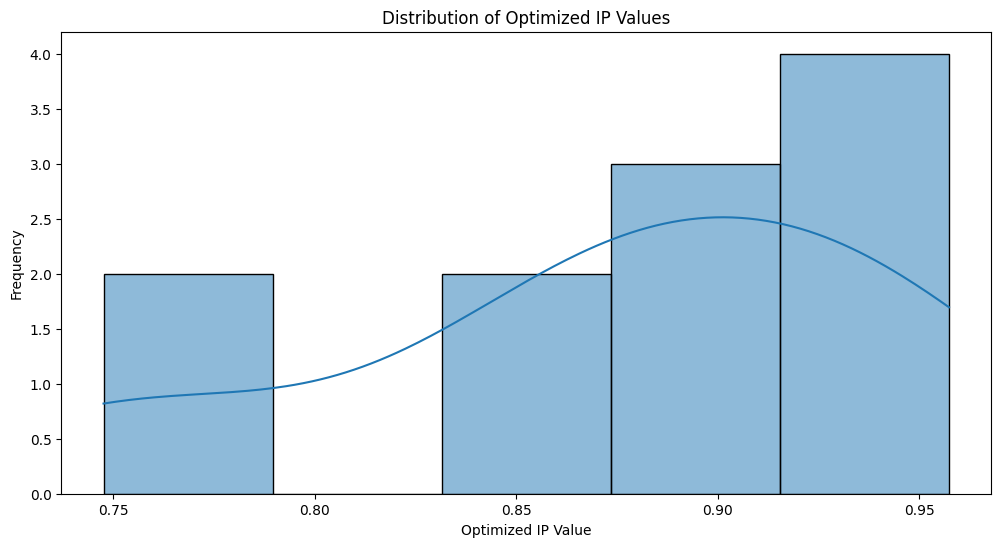

Visualizing GA for sample fund: CMF1_stable_sections
Running GA visualization for sample fund: CMF1_stable_sections
gen	nevals	max     
0  	50    	0.249104
1  	41    	1       
2  	39    	1       
3  	41    	0.259489
4  	36    	0.259489
5  	39    	0.259489
6  	38    	0.259489
7  	42    	0.259489
8  	39    	0.259489
9  	42    	0.259489
10 	35    	0.259489
11 	41    	0.259489
12 	39    	0.259489
13 	41    	0.259489
14 	33    	0.259489
15 	42    	0.259489
16 	41    	0.259489
17 	38    	0.259489
18 	38    	0.259489
19 	34    	0.259489
20 	27    	0.259489
21 	41    	0.259489
22 	37    	0.259489
23 	34    	0.259489
24 	36    	0.259489
25 	43    	0.259489
26 	42    	0.259489
27 	44    	0.259489
28 	40    	1       
29 	38    	0.259489
30 	39    	0.259489
31 	40    	0.259489
32 	40    	0.259489
33 	39    	0.259489
34 	34    	0.259489
35 	34    	0.259489
36 	40    	0.259489
37 	35    	0.259489
38 	39    	0.259489
39 	40    	0.259489
40 	44    	0.259489
41 	36    	0.259489
42 	40    	0.259489
43 	

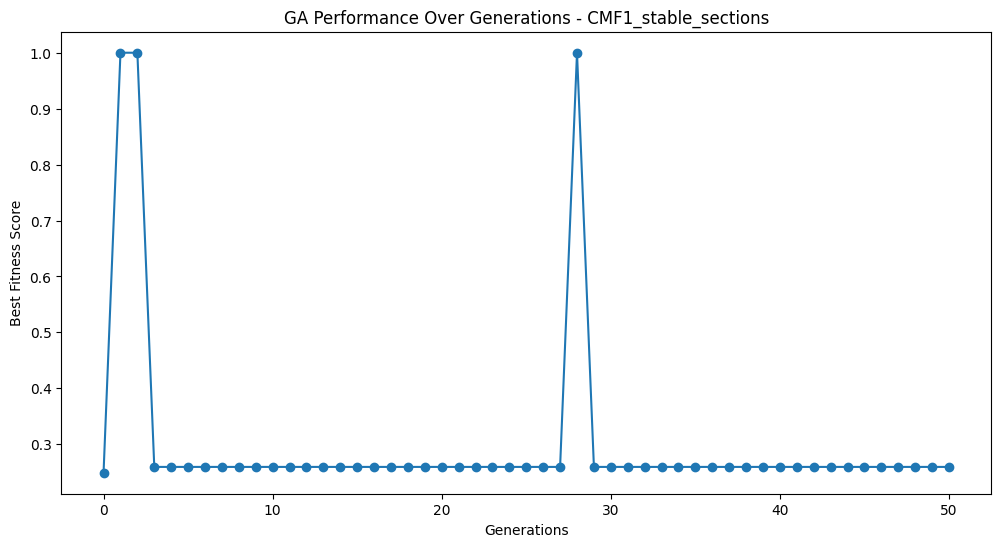

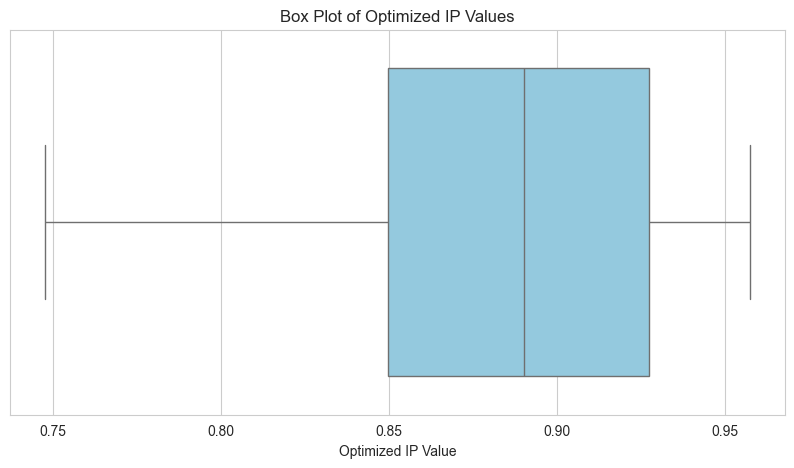

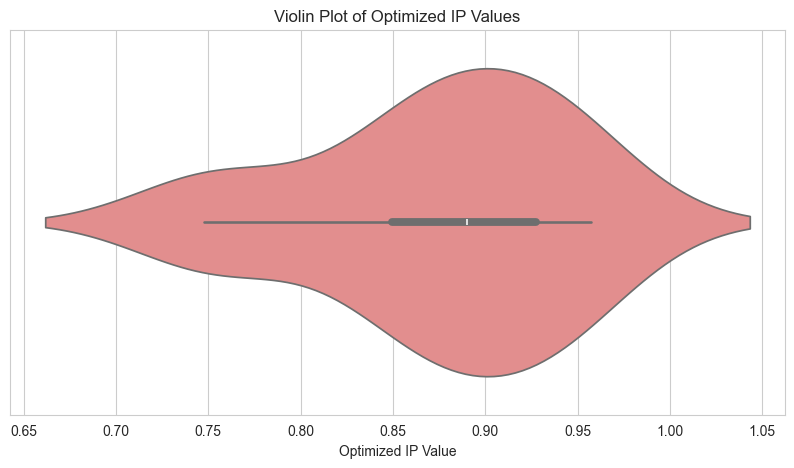

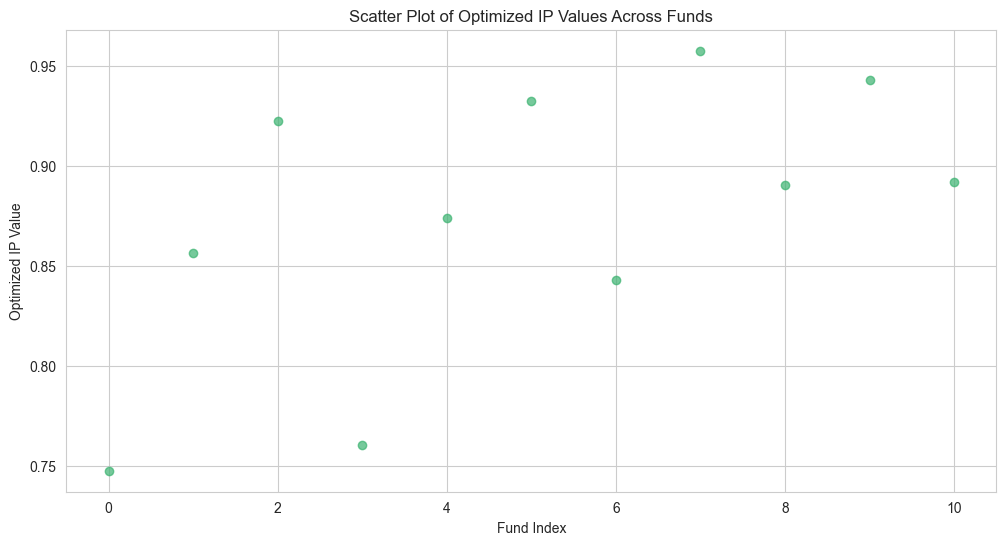

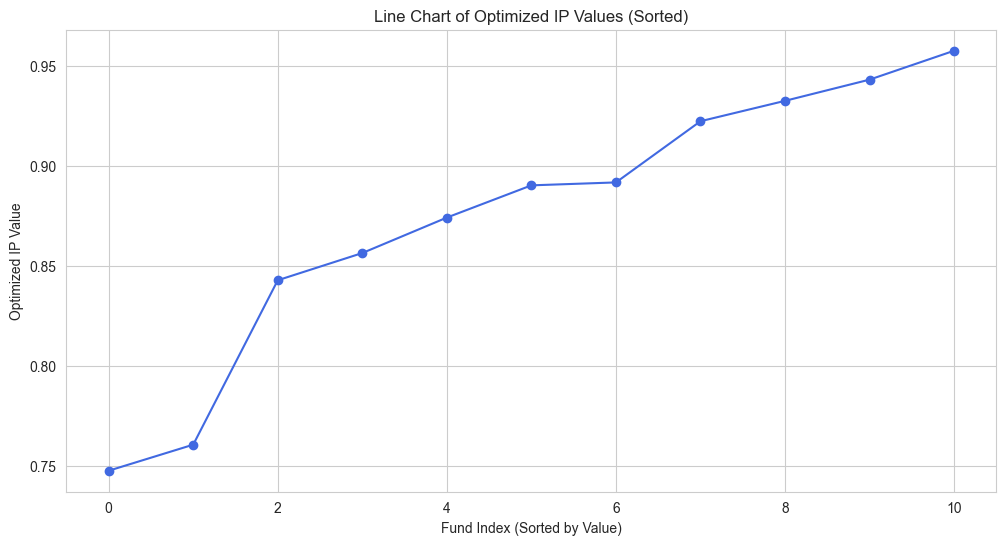

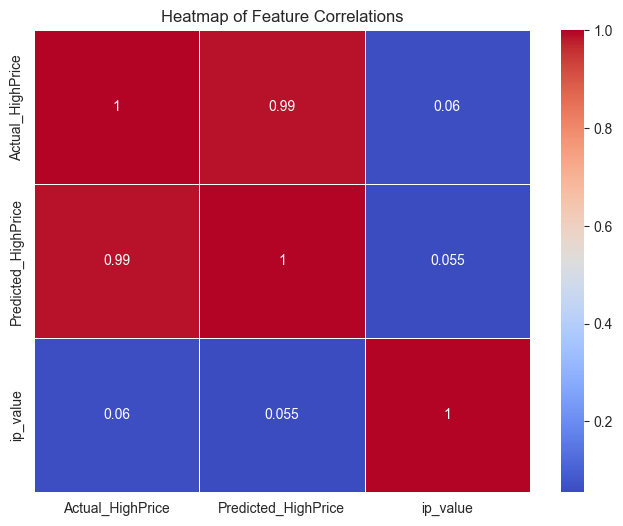

Total execution time: 8633.48 seconds


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
from itertools import product
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
import time

# Debugging: Track start time
start_time = time.time()
print("Program started...")

# Load dataset
file_path = "all_funds_final_results.csv"
print("Loading dataset...")
data = pd.read_csv(file_path)
print("Dataset loaded successfully.")

# Keep relevant columns
data = data[["Fund", "Section", "Index", "Actual_HighPrice", "Predicted_HighPrice", "ip_value"]]

# Compute returns
data["Return"] = (data["Predicted_HighPrice"] - data["Actual_HighPrice"]) / data["Actual_HighPrice"]
print("Returns computed.")

# Adaptive Mutation Function
def adaptive_mutation(individual, generation, max_generations):
    base_mutation = 0.05
    max_mutation = 0.3
    decay_factor = (max_mutation - base_mutation) * (1 - generation / max_generations)
    mutation_rate = base_mutation + decay_factor
    tools.mutGaussian(individual, mu=0, sigma=0.2, indpb=mutation_rate)
    return individual,

# Multi-Objective Fitness Function
def sharpe_with_volatility(threshold, asset_data):
    selected_data = asset_data[asset_data["ip_value"] >= threshold]
    if selected_data.empty:
        return (-1.0, 1.0)
    portfolio_return = selected_data["Return"].mean()
    portfolio_std = selected_data["Return"].std()
    if portfolio_std <= 1e-5:
        return (-1.0, 1.0)
    sharpe = portfolio_return / portfolio_std
    return (sharpe, portfolio_std)

# Genetic Algorithm Setup
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -0.5))  
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, data["ip_value"].min(), data["ip_value"].max())
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)  
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)
print("Genetic Algorithm setup complete.")

# Grid Search Hyperparameters
pop_sizes = [30, 50, 100]
crossover_rates = [0.6, 0.75, 0.9]
mutation_rates = [0.05, 0.1, 0.2]
generations_list = [20, 50, 100]

# Cross-validation setup
kf = KFold(n_splits=5)

def run_ga_for_fund(fund_data, pop_size, crossover_rate, mutation_rate, generations):
    """Runs the genetic algorithm and returns the best individual (IP value)."""
    
    def evaluate(individual):
        return sharpe_with_volatility(individual[0], fund_data)

    # Register evaluation only once
    toolbox.register("evaluate", evaluate)
    toolbox.register("mutate", adaptive_mutation, generation=generations, max_generations=generations)

    population = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)  # Stores the best individual

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)

    print(f"Running GA for population {pop_size}, crossover {crossover_rate}, mutation {mutation_rate}, generations {generations}")
    algorithms.eaSimple(population, toolbox, cxpb=crossover_rate, 
                        mutpb=mutation_rate, ngen=generations, 
                        stats=stats, halloffame=hof, verbose=False)

    best_individual = hof[0]  # Get the best individual
    best_ip = best_individual[0]  # Extract best IP value

    return best_ip

# Run GA for each fund
optimized_thresholds = []
fund_list = data["Fund"].unique()
print(f"Processing {len(fund_list)} funds...")

for fund in fund_list:
    print(f"\nStarting GA for fund: {fund}")
    fund_data = data[data["Fund"] == fund]
    best_fitness = -np.inf
    best_ip_value = None

    for pop_size, crossover_rate, mutation_rate, generations in product(pop_sizes, crossover_rates, mutation_rates, generations_list):
        fold_best_ip_values = []
        fold_best_fitness_values = []

        for train_idx, test_idx in kf.split(fund_data):
            train_data = fund_data.iloc[train_idx]

            # Run GA and get the best IP value
            best_ip = run_ga_for_fund(train_data, pop_size, crossover_rate, mutation_rate, generations)

            fold_best_ip_values.append(best_ip)

        # Get the best overall IP value
        avg_best_ip = np.mean(fold_best_ip_values)

        if avg_best_ip > best_fitness:
            best_fitness = avg_best_ip
            best_ip_value = avg_best_ip

    optimized_thresholds.append({"Fund": fund, "Optimized_IP_Value": best_ip_value})
    print(f"GA completed for fund: {fund}. Best Optimized IP Value: {best_ip_value}")

# Save results
print("Saving results...")
results_df = pd.DataFrame(optimized_thresholds)
results_df.to_csv("optimized_ip_values.csv", index=False)
print("Results saved successfully!")

